# Data C102 Fall 2021 Final Project - Steven
My contributions to the final project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import mannwhitneyu
from itertools import combinations

sns.set_style(style='darkgrid')
plt.style.use('ggplot')
%matplotlib inline

## Data cleaning
Code ~stolen~ adapted from the main project notebook

In [2]:
# Load data into DataFrames
asthma = pd.read_csv('data/asthma.csv')
pm25 = pd.read_csv('data/pm25.csv')
states = pd.read_csv('data/states.csv')
fips = pd.read_csv('https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv')
state_pops = pd.read_csv('data/nst-est2019-alldata.csv')

*For hypothesis testing*:

In [3]:
# Add divisions to the asthma data
asthma_states = asthma.merge(states, left_on='LocationAbbr', right_on='State Code').drop(columns=['State', 'State Code'])
asthma_states.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Region,Division
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN,South,East South Central
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN,South,East South Central
2,2015,2015,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN,South,East South Central
3,2013,2013,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Crude Rate,...,AST4_1,CRDRATE,OVERALL,OVR,NaN,NaN,NaN,NaN,South,East South Central
4,2016,2016,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Age-adjusted Rate,...,AST4_1,AGEADJRATE,RACE,WHT,NaN,NaN,NaN,NaN,South,East South Central


In [4]:
# Query for overall age-adjusted prevalence
asthma_aap = asthma_states.query(
        'Question == "Current asthma prevalence among adults aged >= 18 years"' + 
        '& StratificationCategory1 == "Overall"' +
        '& DataValueType == "Age-adjusted Prevalence"' # Asthma prevalence is expressed as a percentage of the overall population
    )[['YearStart', 'LocationAbbr', 'LocationDesc', 'Division', 'DataValue']].rename(
        columns={'YearStart': 'year',
                 'LocationAbbr': 'state',
                 'LocationDesc': 'stname',
                 'Division': 'div',
                 'DataValue': 'aap'}
    ).reset_index().drop(columns='index')
asthma_aap.head()

,year,state,stname,div,aap
0,2019,AL,Alabama,East South Central,9.4
1,2015,AL,Alabama,East South Central,9.9
2,2017,AL,Alabama,East South Central,10.9
3,2013,AL,Alabama,East South Central,8.5
4,2011,AL,Alabama,East South Central,8.0


In [5]:
# Fill the only NA value with the average age-adjusted prevalence in NJ
NJ_aap_mean = round(asthma_aap.query('state == "NJ"').mean()['aap'], 1)
asthma_aap = asthma_aap.fillna(value={'aap': NJ_aap_mean})
asthma_aap.query('state == "NJ"')

,year,state,stname,div,aap
351,2011,NJ,New Jersey,Middle Atlantic,9.0
352,2012,NJ,New Jersey,Middle Atlantic,8.8
353,2014,NJ,New Jersey,Middle Atlantic,8.3
354,2016,NJ,New Jersey,Middle Atlantic,8.2
355,2018,NJ,New Jersey,Middle Atlantic,8.4
356,2015,NJ,New Jersey,Middle Atlantic,7.3
357,2019,NJ,New Jersey,Middle Atlantic,8.4
358,2017,NJ,New Jersey,Middle Atlantic,8.4
359,2013,NJ,New Jersey,Middle Atlantic,9.0


In [6]:
# Calculate weighted average age-adjusted prevalence for each division
state_pop_means_df = pd.DataFrame( # Calculate mean population in each state over the years 2011-2019
        list(
            map(
                lambda x: [x[0], round(np.mean(x[1:]), 0)], 
                state_pops.query('SUMLEV == 40')[['NAME'] + list(state_pops.columns[8:17])].to_numpy()
            )
        )
    ).rename(columns={1: 'pop_mean'})

asthma_aap_pop_means = asthma_aap.merge(# Merge mean population with AAP DataFrame
        state_pop_means_df, 
        left_on='stname', 
        right_on=0
    ).drop(columns=0) 

asthma_aap_pop_means['asthma_est'] = (asthma_aap_pop_means['aap'] * asthma_aap_pop_means['pop_mean'] / 100).apply( # Calculate estimated number of people with asthma
        lambda x: round(x, 0)
    ) 

asthma_div_agg = asthma_aap_pop_means.groupby(# Add up the components for calculating the weighted averages
        ['year', 'div']
    )[['pop_mean', 'asthma_est']].sum() 

asthma_aap_div = (100 * asthma_div_agg['asthma_est'] / asthma_div_agg['pop_mean']).apply(
        lambda x: round(x, 1)
    ).unstack( # Calculate the weighted averages
        level=0
    ).apply(lambda x: x / 100) # Convert to proportions

asthma_aap_div

year,2011,2012,2013,2014,2015,2016,2017,2018,2019
div,,,,,,,,,
East North Central,0.093,0.095,0.097,0.103,0.096,0.096,0.096,0.097,0.101
East South Central,0.082,0.087,0.081,0.095,0.098,0.103,0.101,0.102,0.092
Middle Atlantic,0.094,0.094,0.095,0.099,0.095,0.096,0.094,0.097,0.097
Mountain,0.090,0.087,0.087,0.090,0.090,0.091,0.096,0.093,0.096
New England,0.109,0.107,0.112,0.111,0.106,0.108,0.115,0.108,0.108
Pacific,0.088,0.091,0.091,0.082,0.082,0.083,0.085,0.089,0.084
South Atlantic,0.085,0.083,0.085,0.083,0.082,0.081,0.086,0.091,0.082
West North Central,0.081,0.086,0.088,0.088,0.084,0.085,0.086,0.088,0.090
West South Central,0.077,0.073,0.076,0.072,0.079,0.080,0.079,0.081,0.076


In [7]:
asthma_aap_div_melt = asthma_aap_div.melt(
        ignore_index=False
    ).reset_index().rename(
        columns={'value': 'aap_w'}
    ).sort_values(['div', 'year'], ignore_index=True)

asthma_aap_div_melt.head(10)

,div,year,aap_w
0,East North Central,2011,0.093
1,East North Central,2012,0.095
2,East North Central,2013,0.097
3,East North Central,2014,0.103
4,East North Central,2015,0.096
5,East North Central,2016,0.096
6,East North Central,2017,0.096
7,East North Central,2018,0.097
8,East North Central,2019,0.101
9,East South Central,2011,0.082


*For causal inference*:

In [8]:
# Add state names to the PM2.5 data
pm25_states = pm25.merge(
        fips, 
        left_on='statefips', 
        right_on=' st'
    ).drop(
        columns=['ds_pm_stdd', 'statefips', ' st']
    ).rename(
        columns={' stusps': 'state'}
    )[['year', 'state', 'stname', 'ds_pm_pred']]
pm25_states.head()

,year,state,stname,ds_pm_pred
0,2011,AL,Alabama,10.696324
1,2012,AL,Alabama,10.396601
2,2013,AL,Alabama,10.039805
3,2014,AL,Alabama,11.007064
4,2011,DE,Delaware,9.671609


In [9]:
# Merge AAP data with PM2.5 data
pm25_asthma = pm25_states.merge(
        asthma_aap,
        how='left',
        on=['year', 'stname']
    ).drop(
        columns='state_y'
    ).rename(
        columns={'state_x': 'state'}
    )[['year', 'state', 'div', 'ds_pm_pred', 'aap']]
pm25_asthma.head()

,year,state,div,ds_pm_pred,aap
0,2011,AL,East South Central,10.696324,8.0
1,2012,AL,East South Central,10.396601,8.5
2,2013,AL,East South Central,10.039805,8.5
3,2014,AL,East South Central,11.007064,9.5
4,2011,DE,South Atlantic,9.671609,10.0


## Multiple hypothesis testing
First, we check visually that the assumption of normality is valid:

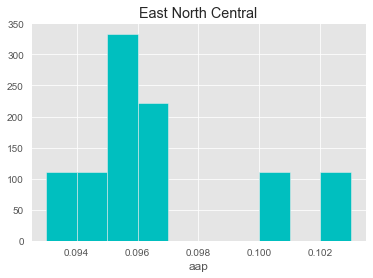

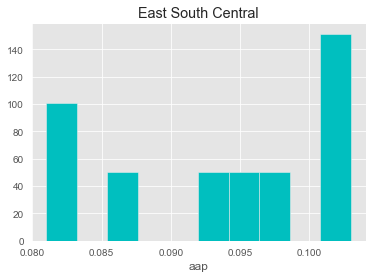

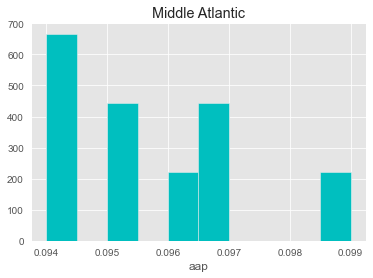

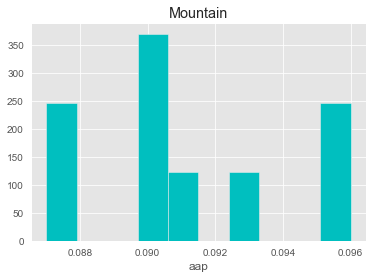

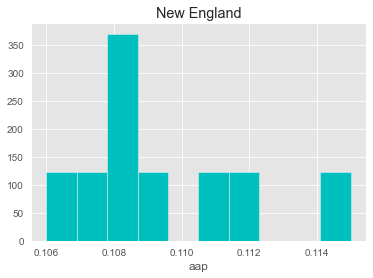

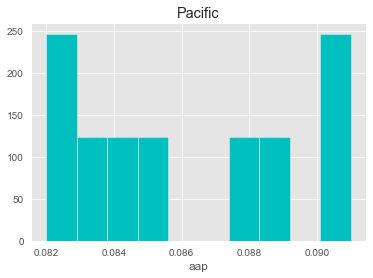

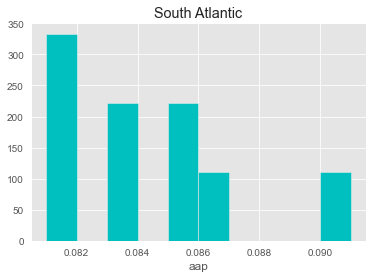

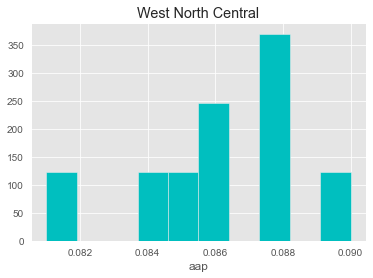

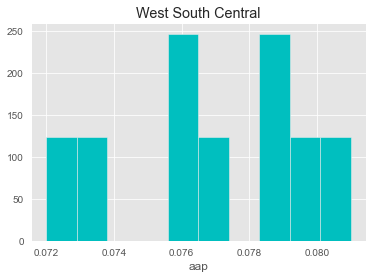

In [10]:
# Adapted from Brighten's notebook
for div in asthma_aap_div_melt.value_counts('div').index:
    plt.figure(div);
    plt.hist(asthma_aap_div_melt.query('div == "' + div + '"')['aap_w'], density=1, color='c');
    plt.xlabel('aap');
    plt.title(div);

<Figure size 432x288 with 0 Axes>

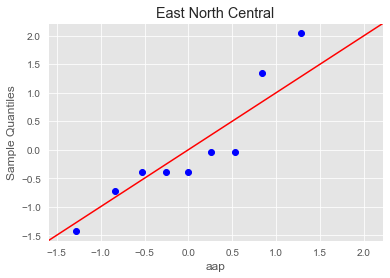

<Figure size 432x288 with 0 Axes>

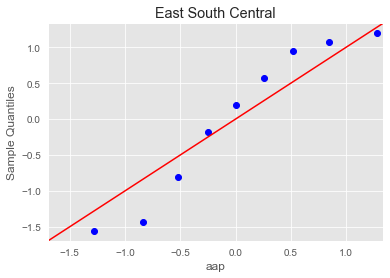

<Figure size 432x288 with 0 Axes>

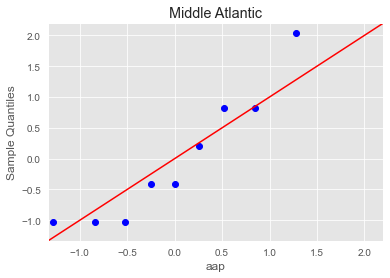

<Figure size 432x288 with 0 Axes>

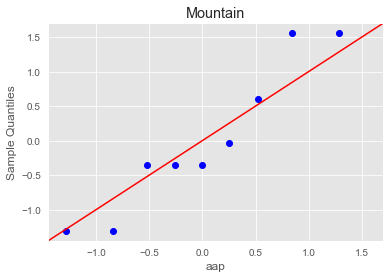

<Figure size 432x288 with 0 Axes>

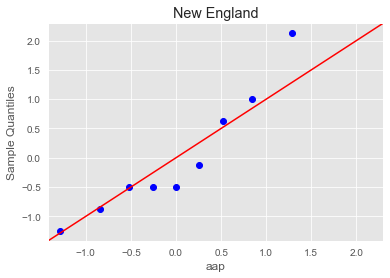

<Figure size 432x288 with 0 Axes>

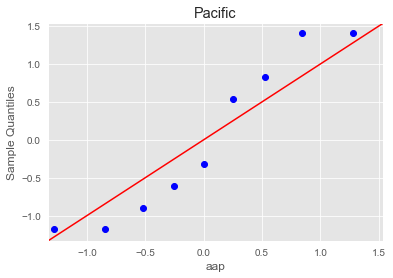

<Figure size 432x288 with 0 Axes>

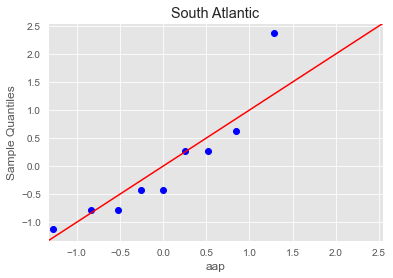

<Figure size 432x288 with 0 Axes>

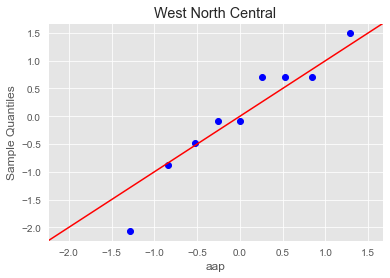

<Figure size 432x288 with 0 Axes>

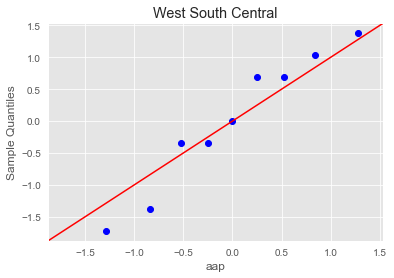

In [11]:
# Also adapted from Brighten (not stealing, I promise!) 
for div in asthma_aap_div_melt.value_counts('div').index:
    plt.figure(div);
    sm.qqplot(asthma_aap_div_melt.query('div == "' + div + '"')['aap_w'], line='45', fit=True);
    plt.xlabel('aap');
    plt.title(div);

Statistically, we assume that for a given state, each sampled proportion is independentally and identically distributed according to some normal distribution that is particular to that given state. The weighted mean for a given division is thus a linear combination of normally distributed random variables, so it itself should also be normally distributed.

Using the weighted rates, we perform two-sided $t$-tests between every pair of divisions:

we can get nice, rejectable p-values if we use ttest_rel which:

'Calculate the t-test on TWO RELATED samples of scores, a and b.

This is a two-sided test for the null hypothesis that 2 related or repeated samples have identical average (expected) values.'

It would be nice if we could justify that the samples are related. I'm wondering if we can use the fact that our hypothesis assumes that all of these distributions are the same(ie geographic location does NOT affect astham prevelance)

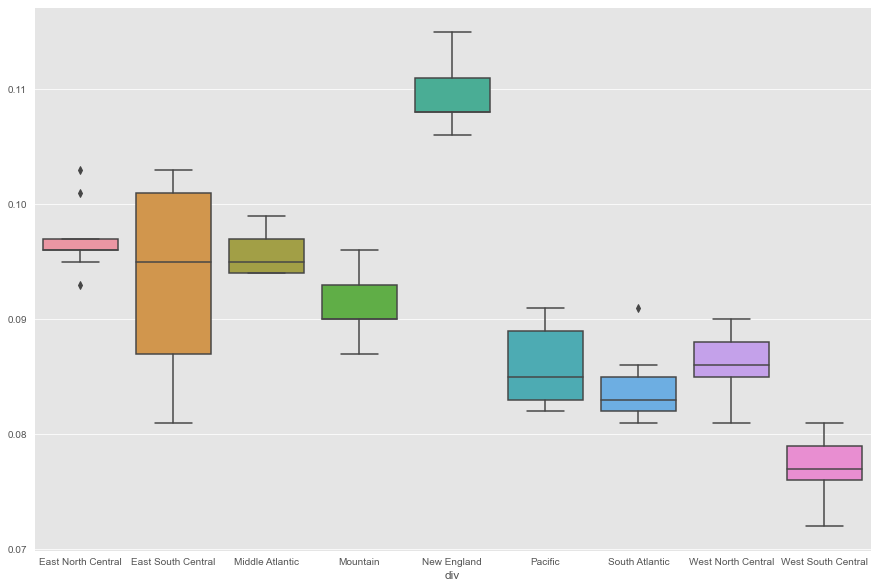

In [12]:
plt.figure(figsize = (15,10))
sns.boxplot(data=asthma_aap_div.T);

In [13]:
aap_div_samples = list(zip(asthma_aap_div.index, asthma_aap_div.values))
aap_div_samples

[('East North Central',
  array([0.093, 0.095, 0.097, 0.103, 0.096, 0.096, 0.096, 0.097, 0.101])),
 ('East South Central',
  array([0.082, 0.087, 0.081, 0.095, 0.098, 0.103, 0.101, 0.102, 0.092])),
 ('Middle Atlantic',
  array([0.094, 0.094, 0.095, 0.099, 0.095, 0.096, 0.094, 0.097, 0.097])),
 ('Mountain',
  array([0.09 , 0.087, 0.087, 0.09 , 0.09 , 0.091, 0.096, 0.093, 0.096])),
 ('New England',
  array([0.109, 0.107, 0.112, 0.111, 0.106, 0.108, 0.115, 0.108, 0.108])),
 ('Pacific',
  array([0.088, 0.091, 0.091, 0.082, 0.082, 0.083, 0.085, 0.089, 0.084])),
 ('South Atlantic',
  array([0.085, 0.083, 0.085, 0.083, 0.082, 0.081, 0.086, 0.091, 0.082])),
 ('West North Central',
  array([0.081, 0.086, 0.088, 0.088, 0.084, 0.085, 0.086, 0.088, 0.09 ])),
 ('West South Central',
  array([0.077, 0.073, 0.076, 0.072, 0.079, 0.08 , 0.079, 0.081, 0.076]))]

In [14]:
mannwhitneyu(aap_div_samples[0][1], aap_div_samples[8][1])

MannwhitneyuResult(statistic=0.0, pvalue=0.0001963708858472698)

In [15]:
# Apply the Mann-Whitney non-parametric test for each pair of divisions
aap_div_pvals = list()

for div1, div2 in combinations(aap_div_samples, 2):
    aap_div_pvals.append({
        'div1': div1[0],
        'div2': div2[0],
        'mw_pval': mannwhitneyu(div1[1], div2[1])[1]
    })
    
aap_div_pvals_df = pd.DataFrame(aap_div_pvals)
aap_div_pvals_df.head(10)        

,div1,div2,mw_pval
0,East North Central,East South Central,0.253020
1,East North Central,Middle Atlantic,0.151394
2,East North Central,Mountain,0.001803
3,East North Central,New England,0.000194
4,East North Central,Pacific,0.000196
5,East North Central,South Atlantic,0.000195
6,East North Central,West North Central,0.000192
7,East North Central,West South Central,0.000196
8,East South Central,Middle Atlantic,0.464654
9,East South Central,Mountain,0.212309


In [16]:
# Code adapted from lab01

def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    m = len(p_values)
    decisions = p_values <= (alpha_total/m)
    return decisions

def benjamini_hochberg(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    n = len(p_values)
    K = np.arange(n)
    p_values_copy = p_values.copy()
    p_values_copy.sort()
    
    opt_p = 0
    
    for k in K:
        if p_values_copy[k] <= [(k+1)*alpha/n]:
            opt_p = p_values_copy[k]
   
    decisions = p_values <= opt_p
    return decisions

In [17]:
alpha = 0.05 # Significance level
pvals = aap_div_pvals_df['mw_pval'].to_numpy()

# Apply p-value correction methods
aap_div_none = (pvals <= alpha)
aap_div_bon = bonferroni(pvals, alpha)
aap_div_BH = benjamini_hochberg(pvals, alpha)

aap_div_decisions = aap_div_pvals_df.assign(none_decision=aap_div_none, bon_decision=aap_div_bon, bh_decision=aap_div_BH)
aap_div_decisions

,div1,div2,mw_pval,none_decision,bon_decision,bh_decision
0,East North Central,East South Central,0.253020,False,False,False
1,East North Central,Middle Atlantic,0.151394,False,False,False
2,East North Central,Mountain,0.001803,True,False,True
3,East North Central,New England,0.000194,True,True,True
4,East North Central,Pacific,0.000196,True,True,True
5,East North Central,South Atlantic,0.000195,True,True,True
6,East North Central,West North Central,0.000192,True,True,True
7,East North Central,West South Central,0.000196,True,True,True
8,East South Central,Middle Atlantic,0.464654,False,False,False
9,East South Central,Mountain,0.212309,False,False,False


In [18]:
aap_div_decisions[['none_decision', 'bon_decision', 'bh_decision']].sum()

none_decision    29
bon_decision     22
bh_decision      27
dtype: int64

In [19]:
aap_div_decisions[lambda df: df['bh_decision']]

,div1,div2,mw_pval,none_decision,bon_decision,bh_decision
2,East North Central,Mountain,0.001803,True,False,True
3,East North Central,New England,0.000194,True,True,True
4,East North Central,Pacific,0.000196,True,True,True
5,East North Central,South Atlantic,0.000195,True,True,True
6,East North Central,West North Central,0.000192,True,True,True
7,East North Central,West South Central,0.000196,True,True,True
10,East South Central,New England,0.000201,True,True,True
12,East South Central,South Atlantic,0.018642,True,False,True
14,East South Central,West South Central,0.000239,True,True,True
15,Middle Atlantic,Mountain,0.004928,True,False,True


## Graveyard
Code that didn't make the cut

In [20]:
from scipy.stats import ttest_ind_from_stats

def ttest_ind_props(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    phat1 = np.mean(sample1)
    phat2 = np.mean(sample2)
    s_phat1 = np.sqrt(phat1 * (1 - phat1) / (n1 - 1))
    s_phat2 = np.sqrt(phat2 * (1 - phat2) / (n2 - 1))
    
    return ttest_ind_from_stats(
            mean1=phat1, std1=s_phat1, nobs1=n1,
            mean2=phat2, std2=s_phat2, nobs2=n2,
            alternative='two-sided'
        )

In [21]:
asthma_aap_list = asthma_aap.sort_values(
        ['stname', 'year']
    ).groupby(
        'stname'
    ).agg(
        {'aap': list}
    ).reset_index().rename(
        columns={'aap': 'aaps'}
    ).merge(states, left_on='stname', right_on='State').drop(
        columns=['State', 'State Code', 'Region']
    ).rename(
        columns={'Division': 'div'}
    )[['stname', 'div', 'aaps']]

asthma_aap_list

,stname,div,aaps
0,Alabama,East South Central,"[8.0, 8.5, 8.5, 9.5, 9.9, 9.8, 10.9, 10.4, 9.4]"
1,Alaska,Pacific,"[8.5, 9.1, 9.4, 8.2, 9.3, 9.0, 8.4, 9.0, 9.7]"
2,Arizona,Mountain,"[9.6, 8.7, 8.9, 9.7, 9.3, 9.3, 9.7, 10.0, 9.8]"
3,Arkansas,West South Central,"[9.5, 8.7, 8.2, 8.7, 10.0, 8.5, 9.7, 9.8, 9.3]"
4,California,Pacific,"[8.4, 8.8, 8.7, 7.7, 7.6, 7.7, 7.8, 8.5, 7.8]"
5,Colorado,Mountain,"[8.3, 8.9, 8.7, 8.3, 9.1, 8.8, 9.3, 9.2, 9.7]"
6,Connecticut,New England,"[10.1, 10.1, 10.0, 9.3, 10.7, 10.6, 10.9, 10.1..."
7,Delaware,South Atlantic,"[10.0, 10.0, 10.7, 8.7, 9.0, 8.7, 10.5, 10.3, ..."
8,District of Columbia,South Atlantic,"[10.0, 10.1, 11.9, 11.3, 10.6, 10.1, 9.1, 11.8..."
9,Florida,South Atlantic,"[7.6, 8.1, 8.2, 8.0, 7.5, 6.7, 7.5, 8.7, 7.3]"


In [22]:
NJ_means = asthma_aap_list.iloc[30, 1]
NJ_means[8] = round(np.mean(NJ_means[0:7]), 1)
asthma_aap_list

TypeError: cannot perform reduce with flexible type

In [ ]:
asthma_aap.value_counts('year')

In [ ]:
state_pops.info(verbose=True)

In [ ]:
state_pops_list = state_pops.query('SUMLEV == 40').melt(
        id_vars='NAME', 
        value_vars=state_pops.columns[8:17]
    )[['NAME', 'value']].groupby('NAME').agg(list).reset_index().rename(
        columns={'NAME': 'stname', 'value': 'pops'}
    )
state_pops_list

In [ ]:
asthma_aap_pops = asthma_aap_list.merge(state_pops_list, on='stname')
asthma_aap_pops

In [ ]:
state_pop_means = asthma_aap_pops['pops'].apply(lambda x: int(round(np.mean(x), 0))).to_numpy()
asthma_aap_pops